# Import Libraries

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

## Read and preprocess the data that I received from the (mobile-env) emulator

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the CSV file
csv_file = 'resultss.csv'  # Adjust the path to your CSV file as needed
data = pd.read_csv(csv_file)
print(data.head())

# Function to convert string representation of arrays into numpy arrays
def string_to_array(s):
    # Remove square brackets and split by space
    values = s.strip('[]').split()
    # Convert to float and then to a numpy array
    return np.array([float(v) for v in values])

# Apply this function to the 'Observation' column
data['Observation'] = data['Observation'].apply(string_to_array)

# Filter data for source domain (Agent_ID = 1) and target domain (Agent_ID = 2)
source_data = data[data['Agent_ID'] == 1]
target_data = data[data['Agent_ID'] == 2]

# Extracting features and labels for the source domain
X_source = np.stack(source_data['Observation'].values)
y_source = source_data['Action'].values

# Extracting features and labels for the target domain
X_target = np.stack(target_data['Observation'].values)
y_target = target_data['Action'].values

# Display the first few rows of X_source and y_source for verification
print("\nFirst few rows of X_source:")
print(X_source[:5])
print("\nCorresponding y_source values:")
print(y_source[:5])

   Agent_ID            Observation  Action    Reward
0         1                [0. 0.]       1  5.000000
1         2                [0. 0.]       1  5.000000
2         3                [0. 0.]       1  5.000000
3         4                [0. 0.]       1  5.000000
4         1  [2.4124804 2.5      ]       1  4.879376

First few rows of X_source:
[[0.        0.       ]
 [2.4124804 2.5      ]
 [1.5187798 3.       ]
 [2.0485017 3.5      ]
 [1.6915195 4.       ]]

Corresponding y_source values:
[1 1 1 1 1]


# Plotting the two distributions

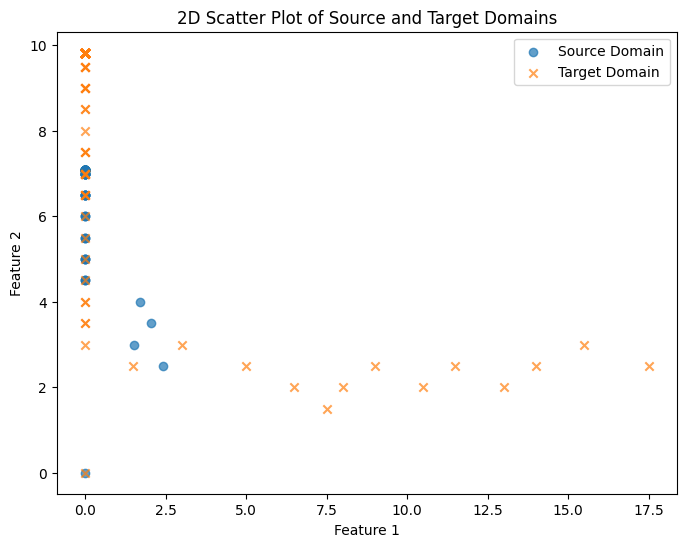

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_source and X_target are defined and are 2D numpy arrays
plt.figure(figsize=(8, 6))

# Scatter plot for X_source
plt.scatter(X_source[:, 0], X_source[:, 1], alpha=0.7, label='Source Domain', marker='o')

# Scatter plot for X_target
plt.scatter(X_target[:, 0], X_target[:, 1], alpha=0.7, label='Target Domain', marker='x')

plt.title('2D Scatter Plot of Source and Target Domains')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Implementation inspired by the following paper:




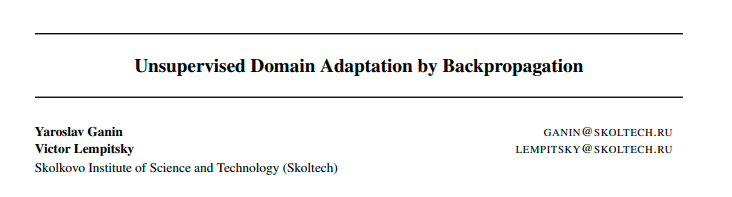

### Architecture:

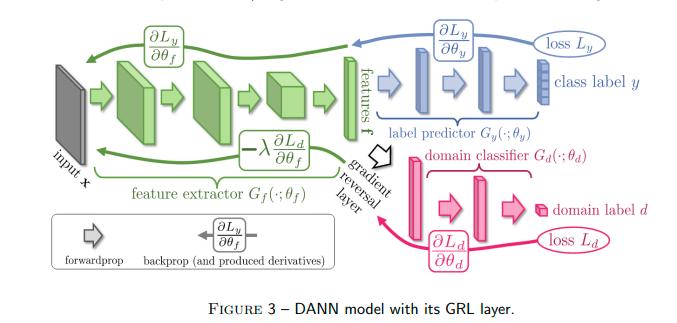

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the network architecture
class DomainAdaptationNN(nn.Module):
    def __init__(self, feature_extractor_out_dim, num_classes):
        super(DomainAdaptationNN, self).__init__()
        # Feature extractor layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, feature_extractor_out_dim),
            nn.ReLU(),
            nn.Linear(feature_extractor_out_dim, feature_extractor_out_dim),
            nn.ReLU()
        )

        # Label predictor layers
        self.label_predictor = nn.Sequential(
            nn.Linear(feature_extractor_out_dim, num_classes)
        )

        # Domain classifier layers
        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_extractor_out_dim, feature_extractor_out_dim),
            nn.ReLU(),
            nn.Linear(feature_extractor_out_dim, 1)  # Binary classification (source/target)
        )

    def forward(self, x, alpha):
        # Forward pass through feature extractor
        features = self.feature_extractor(x)

        # Forward pass through label predictor
        class_outputs = self.label_predictor(features)

        # Flip the gradient when backpropagating through this layer
        reversed_features = ReverseLayerF.apply(features, alpha)

        # Forward pass through domain classifier
        domain_outputs = self.domain_classifier(reversed_features)

        return class_outputs, domain_outputs

class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# Assuming in_features is the number of features in your dataset and num_classes is the number of unique actions
in_features = X_source.shape[1]
num_classes = len(np.unique(y_source))

# Initialize the domain adaptation network
model = DomainAdaptationNN(feature_extractor_out_dim=128, num_classes=num_classes)

# Define loss functions
class_criterion = nn.CrossEntropyLoss()  # For label prediction
domain_criterion = nn.BCEWithLogitsLoss()  # For domain classification

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming the X_source and X_target are numpy arrays and need to be converted to PyTorch tensors
X_source_tensor = torch.tensor(X_source, dtype=torch.float32)
y_source_tensor = torch.tensor(y_source, dtype=torch.long)
X_target_tensor = torch.tensor(X_target, dtype=torch.float32)
y_target_tensor = torch.tensor(y_target, dtype=torch.long)


# Prepare the data loaders
source_dataset = TensorDataset(X_source_tensor, y_source_tensor)
source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)

target_dataset = TensorDataset(X_target_tensor, y_target_tensor)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10  # Define the number of epochs
alpha = 0.5  # Hyperparameter for the gradient reversal layer

def calculate_accuracy_binary(outputs, labels):
    predicted = (outputs > 0).float()
    correct = (predicted == labels).float().sum()
    return 100 * correct / labels.size(0)

def calculate_accuracy_multiclass(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

# Initialize total counters for source and target
total_source_class_loss, total_source_domain_loss, total_source_class_acc, total_source_domain_acc = 0, 0, 0, 0
total_target_class_loss, total_target_domain_loss, total_target_class_acc, total_target_domain_acc = 0, 0, 0, 0

num_epochs = 10  # Define the number of epochs
alpha = 0.5  # Hyperparameter for the gradient reversal layer

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Initialize lists for accumulating losses and accuracies
    source_class_loss, source_domain_loss, source_class_acc, source_domain_acc = [], [], [], []
    target_class_loss, target_class_acc, target_domain_loss, target_domain_acc = [], [], [], []

    for source_data, source_labels in source_loader:
        optimizer.zero_grad()
        class_outputs, domain_outputs = model(source_data, alpha)

        # Source Classification loss and accuracy
        loss_s_label = class_criterion(class_outputs, source_labels)
        class_acc = calculate_accuracy_multiclass(class_outputs, source_labels)

        # Source Domain loss (source domain labels are 0)
        domain_labels = torch.zeros(domain_outputs.size(0), 1, dtype=torch.float32)
        loss_s_domain = domain_criterion(domain_outputs, domain_labels)
        domain_acc = calculate_accuracy_binary(domain_outputs, domain_labels)

        # Combine losses and backpropagate
        loss = loss_s_label + loss_s_domain
        loss.backward()
        optimizer.step()

        # Append source losses and accuracies
        source_class_loss.append(loss_s_label.item())
        source_domain_loss.append(loss_s_domain.item())
        source_class_acc.append(class_acc)
        source_domain_acc.append(domain_acc)

    for target_data, target_labels in target_loader:
        optimizer.zero_grad()

        # Pass the target data through the model
        class_outputs, domain_outputs = model(target_data, alpha)

        # Target Classification loss and accuracy
        loss_t_label = class_criterion(class_outputs, target_labels)
        target_acc = calculate_accuracy_multiclass(class_outputs, target_labels)

        # Target Domain loss (target domain labels are 1)
        domain_labels = torch.ones(domain_outputs.size(0), 1, dtype=torch.float32)
        loss_t_domain = domain_criterion(domain_outputs, domain_labels)

        # Combine losses and backpropagate
        total_loss = loss_t_label + loss_t_domain
        total_loss.backward()
        optimizer.step()

        # Append target losses and accuracies
        target_class_loss.append(loss_t_label.item())
        target_class_acc.append(target_acc)
        target_domain_loss.append(loss_t_domain.item())
        target_domain_acc.append(calculate_accuracy_binary(domain_outputs, domain_labels))

    if epoch == num_epochs - 1:  # If it's the last epoch
        # Calculate statistics for the last epoch
        avg_source_class_loss = sum(source_class_loss) / len(source_class_loss)
        avg_source_domain_loss = sum(source_domain_loss) / len(source_domain_loss)
        avg_source_class_acc = sum(source_class_acc) / len(source_class_acc)
        avg_source_domain_acc = sum(source_domain_acc) / len(source_domain_acc)

        avg_target_class_loss = sum(target_class_loss) / len(target_class_loss)
        avg_target_class_acc = sum(target_class_acc) / len(target_class_acc)
        avg_target_domain_loss = sum(target_domain_loss) / len(target_domain_loss)
        avg_target_domain_acc = sum(target_domain_acc) / len(target_domain_acc)

        # Print the final results from the last epoch
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'[SOURCE] Class loss/acc: {avg_source_class_loss:.5f} / {avg_source_class_acc:.2f}%, '
              f'Domain loss/acc: {avg_source_domain_loss:.5f} / {avg_source_domain_acc:.2f}%')
        print(f'[TARGET] Class loss/acc: {avg_target_class_loss:.5f} / {avg_target_class_acc:.2f}%, '
              f'Domain loss/acc: {avg_target_domain_loss:.5f} / {avg_target_domain_acc:.2f}%')


Epoch 10/10
[SOURCE] Class loss/acc: 0.54275 / 75.00%, Domain loss/acc: 0.67460 / 92.97%
[TARGET] Class loss/acc: 0.64372 / 64.84%, Domain loss/acc: 0.64828 / 66.41%
